In [2]:
%cd /jet/home/tvnguyen/JeansGNN/experiments
%load_ext autoreload
%autoreload 2

/jet/home/tvnguyen/JeansGNN/experiments
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import corner
import astropy.constants as const
import astropy.units as u

# import jax and jaxns dependencies
import jax
from jax.config import config
config.update("jax_enable_x64", True)

import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp
from jax import vmap
import jaxns
from jaxns import ExactNestedSampler
from jaxns import Model
from jaxns import PriorModelGen, Prior
from jaxns import TerminationCondition
from jaxns import analytic_log_evidence

tfpd = tfp.distributions

# import JeansGNN dependencies
import jeans_gnn as jgnn
import utils

%matplotlib inline

INFO[2023-06-01 14:46:20,753]: Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Host CUDA Interpreter
INFO[2023-06-01 14:46:20,755]: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO[2023-06-01 14:46:20,755]: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
INFO[2023-06-01 14:46:24,766]: Created a temporary directory at /tmp/tmp4nv3fslp
INFO[2023-06-01 14:46:24,767]: Writing /tmp/tmp4nv3fslp/_remote_module_non_scriptable.py
INFO[2023-06-01 14:46:26,462]: Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO[2023-06-01 14:46:26,463]: NumExpr defaulting to 8 threads.


As a first step, we load an example dwarf galaxy simulation from the `data` directory.

In [4]:
# Read the example datasets and pick the first galaxy (though any galaxy will work)
dataset_path = 'data/example_data.hdf5'
node_features, graph_features, headers = jgnn.utils.dataset.read_graph_dataset(
    dataset_path, features_list=['pos', 'vel', 'vel_error', 'labels'])

# Pick the first galaxy
pos = node_features['pos'][1]
vel = node_features['vel'][1]
vel_error = node_features['vel_error'][1]
truth_parameters = {
    k: v for k, v in zip(headers['labels_order'], graph_features['labels'][1])}

# Print out the truth parameters and the node features of the first 10 stars
print('True parameters:')
for k, v in truth_parameters.items():
    print(f'{k}: {v}')
print("Node features:")
print("- pos: {}".format(node_features['pos'][0][:10]))
print("- vel: {}".format(node_features['vel'][0][:10]))

True parameters:
dm_gamma: 1.0077498109274279
dm_log_r_dm: -0.633612420092535
dm_log_rho_0: 6.866133214871631
stellar_log_r_star: -1.2141546817176612
df_beta_0: 0.12881816386775002
df_log_r_a: -0.9183926283597472
Node features:
- pos: [[ 0.13504457  0.05950324]
 [-0.03729184 -0.151646  ]
 [-0.11927976 -0.11157647]
 [-0.03330625  0.06756137]
 [-0.00840738  0.03095477]
 [ 0.07772832 -0.04542598]
 [-0.06865919 -0.04856362]
 [ 0.02304553  0.0593613 ]
 [ 0.00202816  0.00174576]
 [ 0.10052064  0.04847484]]
- vel: [ 0.29824803 -0.04545442  0.21565156 -0.46745416 -0.20959343 -0.14228842
  0.66527882  0.53476856  0.24639451 -0.36439535]


In [5]:
# Convert all arrays to jax arrays
pos = jnp.array(pos)
vel = jnp.array(vel)
vel_error = jnp.array(vel_error)
radius_proj = jnp.linalg.norm(pos, axis=-1)

2023-06-01 14:46:28.096559: W external/xla/xla/service/gpu/nvptx_compiler.cc:564] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.1.105). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Define stellar density profile and log-likelihood function

In [6]:
def log_plummer2d(r: jnp.ndarray, L: float, r_star: float) -> jnp.ndarray:
    """ Compute the log density of the 2D Plummer profile.
    Here, r is the projected radius instead of the 3D radius. Equation:
    ```
    log10 rho(r) = log10 L - 2 log10 r_star - 2 log10 (1 + r^2 / r_star^2) - log10 pi
    ```
    where:
        L: luminosity
        r_star: scale radius
    
    Parameters
    ----------
    r: jnp.ndarray
        The radius
    L: float
        The log luminosity
    r_star: float
        The scale radius
    
    Returns
    -------
    jnp.ndarray
        The log density    
    """
    x = r / r_star
    return jnp.log10(L) - 2 * jnp.log10(r_star) - 2 * jnp.log10(1 + x**2) - jnp.log10(jnp.pi)

In [7]:
# compute the observed surface density profile
Sigma, Sigma_lo, Sigma_hi, logR_bins_lo, logR_bins_hi = utils.calc_Sigma(radius_proj)
logR_bins_ce = 0.5 * (logR_bins_lo + logR_bins_hi)
sig_lo = Sigma - Sigma_lo
sig_hi = Sigma_hi - Sigma
V1 = sig_lo * sig_hi
V2 = sig_hi - sig_lo

In [8]:
def prior_model():
    logL = yield Prior(tfpd.Uniform(low=0., high=5.), name='logL')
    logr_star = yield Prior(tfpd.Uniform(low=-2., high=2.), name='logr_star')
    return logL, logr_star

def log_likelihood(logL, logr_star):
    """ Log likelihood function defined as:
    ```
        logL = -0.5 * (Sigma - Sigma_hat)^2 / (V1 - V2 * (Sigma - Sigma_hat))
    ```
    where:
    - Sigma is the light profile as inferred from data
    - Sigma_hat is the estimated light profile
    - V1 and V2

    Parameters:
    -----------
    theta: jnp.ndarray
        The parameters of the model
    """
    L = jnp.float_power(10, logL)
    r_star = jnp.float_power(10, logr_star)

    # compute the estimated surface density profile
    Sigma_hat = jnp.float_power(
        10, log_plummer2d(10**logR_bins_ce, L, r_star))

    # compute the log likelihood
    delta_Sigma = Sigma - Sigma_hat
    return -0.5 * jnp.sum(delta_Sigma**2 / (V1 - V2 * delta_Sigma))

# Create posterior model
model = Model(prior_model=prior_model, log_likelihood=log_likelihood)
model.sanity_check(random.PRNGKey(0), S=100)
log_Z_true = analytic_log_evidence(model=model, S=80)
print(f"True log(Z)={log_Z_true}")

INFO[2023-06-01 14:46:33,517]: Sanity check...
INFO[2023-06-01 14:46:34,198]: Sanity check passed


True log(Z)=-10.035791540435277


In [10]:
# # Create the nested sampler class. In this case without any tuning.
exact_ns = ExactNestedSampler(
    model=model, num_live_points=500, num_parallel_samplers=1,
    max_samples=1e4)

termination_reason, state = exact_ns(random.PRNGKey(42),
                                     term_cond=TerminationCondition(live_evidence_frac=1e-4))
results = exact_ns.to_results(state, termination_reason)

In [11]:
# We can use the summary utility to display results
exact_ns.summary(results)

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 233586
# samples: 6152
# slices: 40500.0
# slices / acceptance: 9.0
# likelihood evals / sample: 38.0
# likelihood evals / slice: 5.7
--------
logZ=-10.02 +- 0.11
H=10.0
ESS=1027
--------
logL: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
logL: 1.965 +- 0.052 | 1.899 / 1.969 / 2.03 | 1.967 | 1.967
--------
logr_star: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
logr_star: -1.202 +- 0.046 | -1.261 / -1.2 / -1.145 | -1.199 | -1.199
--------


WARNING[2023-06-01 14:47:39,565]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


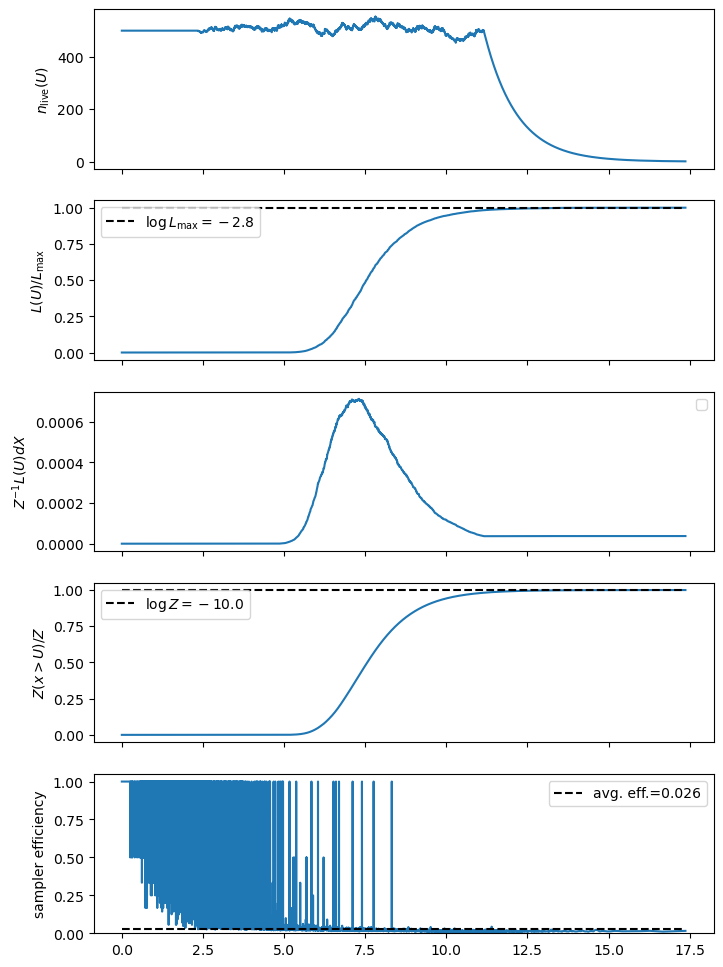

In [12]:
# We plot useful diagnostics and a distribution cornerplot
exact_ns.plot_diagnostics(results)

In [13]:
def resample(results, result_keys, rand_key):
    """ Resample the nested sampler results to obtain samples of the posterior
    distribution. """

    log_p = results.log_dp_mean
    samples = np.stack([results.samples[k] for k in result_keys], axis=-1)
    log_weights = jnp.where(jnp.isfinite(samples).all(1), log_p, -jnp.inf)

    new_samples = jaxns.utils.resample(
        rand_key, samples, log_weights, replace=True)
    return new_samples


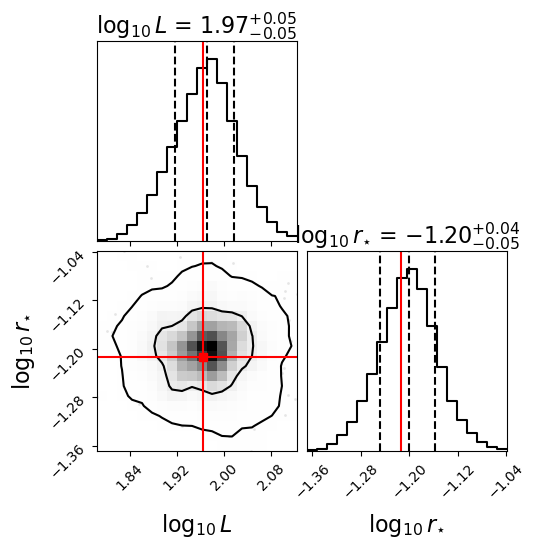

In [14]:
samples = resample(results, ['logL', 'logr_star'], random.PRNGKey(13512))
truths = (
    np.log10(len(pos)), truth_parameters['stellar_log_r_star']
)
labels = [r'$\log_{10} L$', r"$\log_{10} r_{\star}$"]

# Plot all chains
plot_args = dict(
    truth_color='red', truth_alpha=0.5, truth_kwargs={'linewidth': 2},
    label_kwargs={'fontsize': 16}, title_kwargs={'fontsize': 16},
    show_titles=True, levels=[0.68, 0.98], smooth=0.8, smooth1d=1.0, quantiles=[0.16, 0.5, 0.84],
    labels=labels, plot_datapoints=True,
)

figure = corner.corner(
    samples, truths=truths, **plot_args
)
plt.show(block=False)

## Jeans analysis

In [18]:
def log_plummer2d(r: jnp.ndarray, L: float, r_star: float) -> jnp.ndarray:
    """ Compute the log density of the 2D Plummer profile.
    Here, r is the projected radius instead of the 3D radius. Equation:
    ```
    log10 rho(r) = log10 L - 2 log10 r_star - 2 log10 (1 + r^2 / r_star^2) - log10 pi
    ```
    where:
        L: luminosity
        r_star: scale radius
    
    Parameters
    ----------
    r: jnp.ndarray
        The radius
    L: float
        The log luminosity
    r_star: float
        The scale radius
    
    Returns
    -------
    jnp.ndarray
        The log density    
    """
    x = r / r_star
    return jnp.log10(L) - 2 * jnp.log10(r_star) - 2 * jnp.log10(1 + x**2) - jnp.log10(jnp.pi)
    
def log_plummer3d(r: jnp.ndarray, L: float, r_star: float) -> jnp.ndarray:
    """ Compute the log density of the 3D Plummer profile.
    Equation:
    ```
    log10 rho(r) = log10 L - 3 log10 r_star - 5/2 log10 (1 + r^2 / r_star^2) - log10 4 pi / 3
    ```
    where:
        L: luminosity
        r_star: scale radius
    """
    x = r / r_star
    return (jnp.log10(L) - 3 * jnp.log10(r_star) - (5/2) * jnp.log10(1 + x**2)
            - jnp.log10(4 * jnp.pi / 3))

def log_gnfw(
    r: jnp.ndarray, rho_0: float, r_dm: float, gamma: float) -> jnp.ndarray:
    """ Compute the log density of the generalized NFW profile.
    Equation:
    ```
    log10 rho(r) = log10 rho_0 - gamma * log10(r / r_dm) - (3 - gamma) * log10(1 + r / r_dm)
    ```
    where:
        rho_0: central density
        r_dm: dark matter halo scale radius
        gamma: power law index
    """
    x = r / r_dm
    return jnp.log10(rho_0) - gamma * jnp.log10(x) - (3 - gamma) * jnp.log10(1 + x)

def cmass_gnfw(r: jnp.ndarray, rho_0: float, r_dm: float, gamma: float) -> jnp.ndarray:
    """ Compute the cumulative mass of the generalized NFW profile.
    """    
    density = jnp.float_power(10, log_gnfw(r, rho_0, r_dm, gamma))
    res = utils.jax_cumtrapz_init(y=density, x=r, initial=0)
    return res

def beta_om(r: jnp.ndarray, beta_0: float, r_a: float) -> jnp.ndarray:
    """ Compute the velocity anisotropy of the Osipkov-Merrit distribution function.
    Equation:
    ```
    beta(r) = beta_0 * (r / r_a)^2 / (1 + r / r_a)^2
    ```
    where:
        beta_0: central velocity anisotropy
        r_a: scale radius
    """
    x = r / r_a
    return beta_0 * x**2 / (1 + x)**2

In [21]:
# global data
r_min_factor = 0.5
r_max_factor = 2.0
dr = 0.01

# global parameters for liklihood
r_min = jnp.min(radius_proj) * r_min_factor
r_max = jnp.max(radius_proj) * r_max_factor
int_radius = jnp.arange(r_min, r_max, dr)
vel_var = vel_error**2

In [22]:
# prior distribution
min_logrho_0, max_logrho_0 = 5., 8.
min_logr_dm, max_logr_dm = -2., 1.
min_gamma, max_gamma = -1., 2.
min_logL, max_logL = 1.5, 2.5
min_logr_star, max_logr_star = -2, 1.
# min_logL, max_logL = np.percentile(samples[..., 0], [16, 84])
# min_logr_star, max_logr_star = np.percentile(samples[..., 1], [16, 84])
min_logr_a, max_logr_a = -2., 1.
# min_beta_0, max_beta_0 = -0.5, 0.5
min_v_mean, max_v_mean = -200, 200

def prior_model():
    logrho_0 = yield Prior(
        tfpd.Uniform(low=min_logrho_0, high=max_logrho_0), name='logrho_0')
    logr_dm = yield Prior(
        tfpd.Uniform(low=min_logr_dm, high=max_logr_dm), name='logr_dm')
    gamma = yield Prior(
        tfpd.Uniform(low=min_gamma, high=max_gamma), name='gamma')
    logr_star = yield Prior(
        tfpd.Uniform(low=min_logr_star, high=max_logr_star), name='logr_star')
    logL = yield Prior(
        tfpd.Uniform(low=min_logL, high=max_logL), name='logL')
    logr_a = yield Prior(
        tfpd.Uniform(low=min_logr_a, high=max_logr_a), name='logr_a')
    # beta_0 = yield Prior(
        # tfpd.Uniform(low=min_beta_0, high=max_beta_0), name='beta_0')
    v_mean = yield Prior(
        tfpd.Uniform(low=min_v_mean, high=max_v_mean), name='v_mean')
    return logrho_0, logr_dm, gamma, logr_star, logL, logr_a, v_mean

def log_likelihood(
    logrho_0, logr_dm, gamma, logr_star, logL, logr_a, v_mean):
    """ The log likelihood given a set of DM parameters.
    For each star the log likelihood is defined as:
    .. math::
    logL = -0.5 * (v - v_mean)^2 / (sigma2_p + v_err^2) - 0.5 * log(2 pi  * (sigma2_p + verr^2))

    where:
    - v is the velocity of the star
    - v_mean is the mean velocity of all stars
    - v_err is the measurement error
    - sigma2_p is the velocity dispersion
    """
    r_a = jnp.float_power(10, logr_a)
    r_dm = jnp.float_power(10, logr_dm)
    r_star = jnp.float_power(10, logr_star)
    rho_0 = jnp.float_power(10, logrho_0)
    L = jnp.float_power(10, logL)
    beta_0 = 0.12881816386775002

    # First, we calculate the projected velocity dispersion profile
    # calculate the velocity ani Beta(r) and the anisotropy integral g(r)
    beta = beta_om(int_radius, beta_0, r_a)
    gint = utils.calc_gint(int_radius, beta)

    # Calculate the light porilf at each particle radius
    Sigma = jnp.float_power(10, log_plummer2d(radius_proj, L, r_star))

    # calculate the DM density profile at each integration radius
    nu = jnp.float_power(10, log_plummer3d(int_radius, L, r_star))

    # integrate the 3d Jeans velocity dispersion equation
    cmass = cmass_gnfw(int_radius, rho_0, r_dm, gamma)
    sigma2_nu = utils.calc_sigma2_nu(int_radius, cmass, nu, gint)

    # integrate the 2d velocity dispersion equation
    sigma2p_Sigma = utils.calc_sigma2p_Sigma(radius_proj, int_radius, sigma2_nu, beta)
    sigma2p = sigma2p_Sigma / Sigma 
    sigma2p *= const.G.to_value(u.kpc**3 / u.Msun / u.s**2) * utils.kpc_to_km**2

    # calculate the log likelihood from the velocity dispersion
    # and the velocity measurement error
    var = sigma2p + vel_var
    logL = -0.5 * (vel - v_mean)**2 / var
    logL = logL - 0.5 * jnp.log(2 * jnp.pi * var)
    logL = jnp.sum(logL)

    return logL

In [23]:
model = Model(prior_model=prior_model, log_likelihood=log_likelihood)
model.sanity_check(random.PRNGKey(0), S=100)
log_Z_true = analytic_log_evidence(model=model, S=2)

print(f"True log(Z)={log_Z_true}")

INFO[2023-06-01 14:49:32,046]: Sanity check...
INFO[2023-06-01 14:49:32,333]: Sanity check passed


True log(Z)=-666.6904536540836


In [24]:
# Create the nested sampler class. In this case without any tuning.
ns = exact_ns = ExactNestedSampler(
    model=model, num_live_points=1000, num_parallel_samplers=1,
    max_samples=1e5)
termination_reason, state = exact_ns(
    random.PRNGKey(42),
    term_cond=TerminationCondition(live_evidence_frac=0.1))
results = exact_ns.to_results(state, termination_reason)

In [25]:
# We can use the summary utility to display results
exact_ns.summary(results)

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 1328629
# samples: 13303
# slices: 220000.0
# slices / acceptance: 22.0
# likelihood evals / sample: 99.9
# likelihood evals / slice: 6.0
--------
logZ=-131.66 +- 0.11
H=130.0
ESS=468
--------
gamma: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
gamma: -0.3 +- 0.39 | -0.64 / -0.41 / 0.29 | -0.48 | -0.48
--------
logL: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
logL: 1.97 +- 0.34 | 1.52 / 2.09 / 2.29 | 2.27 | 2.27
--------
logr_a: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
logr_a: -1.37 +- 0.68 | -1.88 / -1.62 / -0.27 | -1.63 | -1.63
--------
logr_dm: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
logr_dm: -0.7 +- 0.54 | -1.29 / -0.63 / -0.13 | -1.18 | -1.18
--------
logr_star: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
logr_star: 0.32 +- 0.6 | -0.6 / 0.31 / 0.98 | 0.32 | 0.32
---

WARNING[2023-06-01 14:54:23,359]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


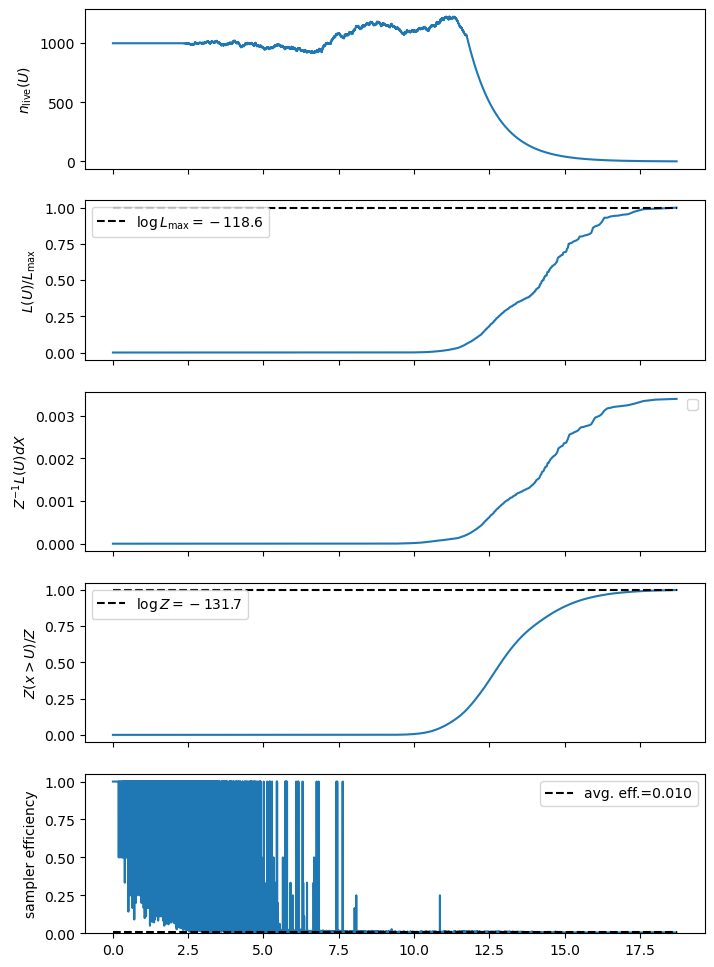

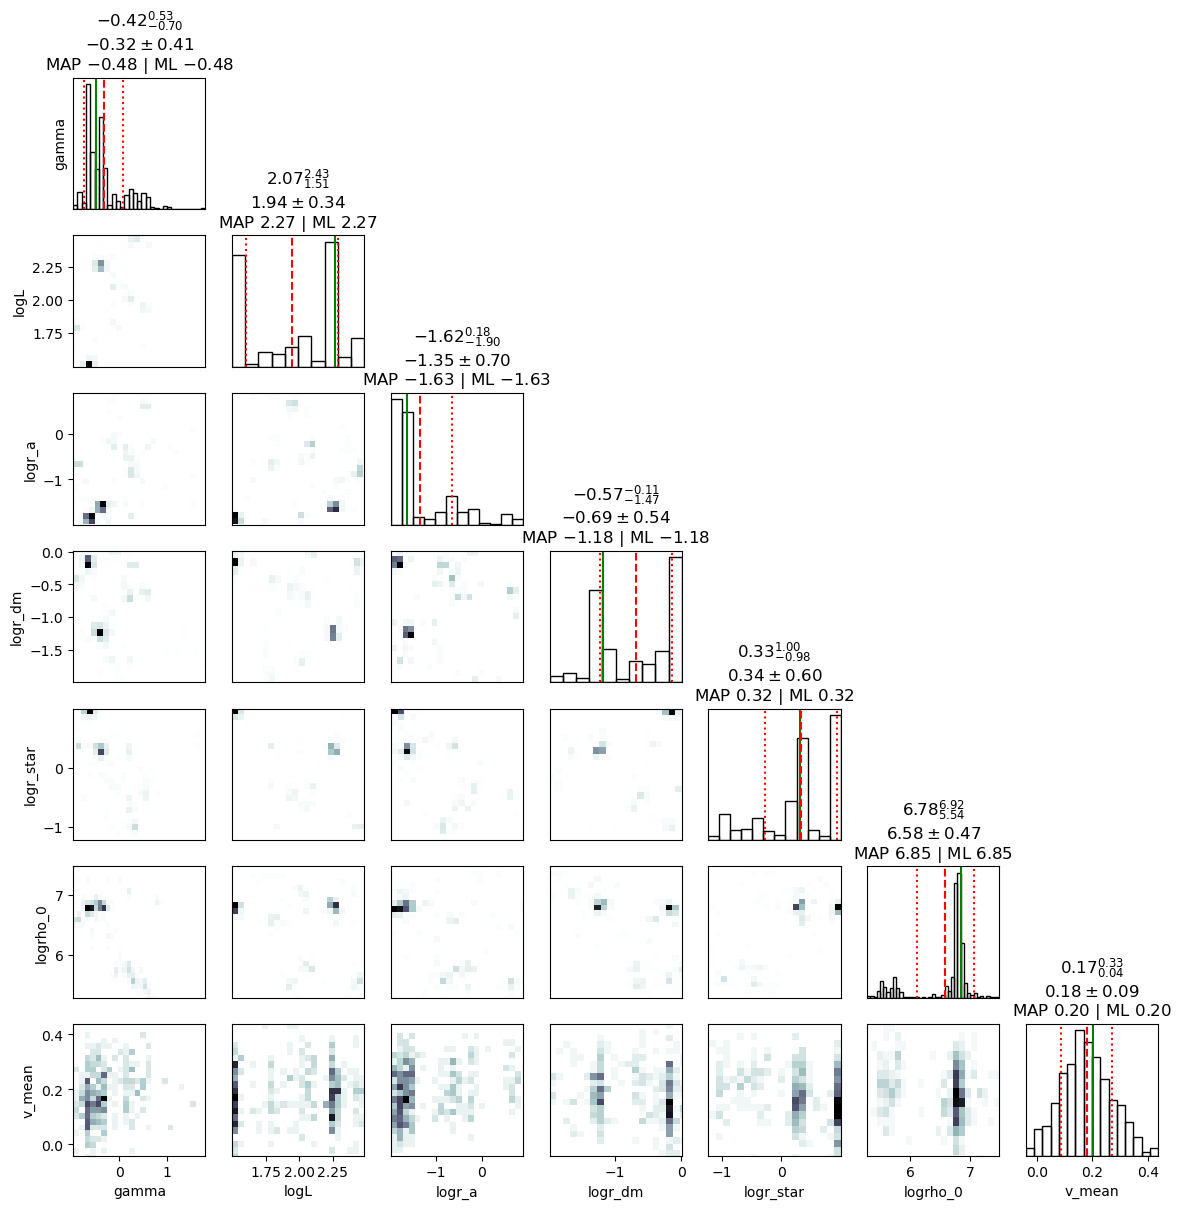

In [26]:
# We plot useful diagnostics and a distribution cornerplot
exact_ns.plot_diagnostics(results)
exact_ns.plot_cornerplot(results)

In [27]:
log_p = results.log_dp_mean
samples = np.stack([
    results.samples['logr_dm'],
    results.samples['gamma'],
    results.samples['logrho_0'],
], axis=-1)
log_weights = jnp.where(jnp.isfinite(samples).all(1), log_p, -jnp.inf)
samples = jaxns.utils.resample(
    random.PRNGKey(4042), samples, log_weights, replace=True)

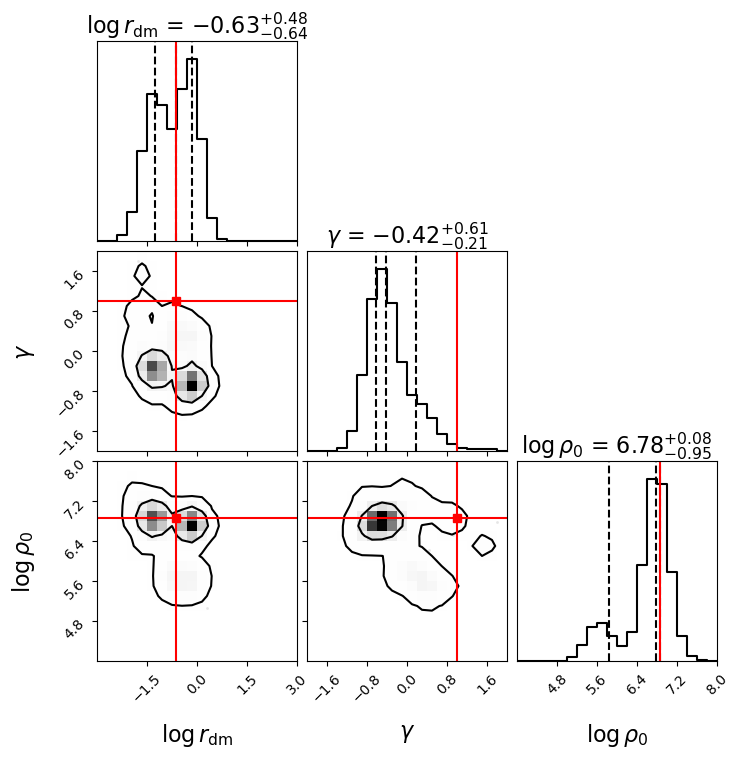

In [28]:
labels = [r"$\log r_{\rm dm}$", r"$\gamma$", r"$\log \rho_0$"]
truths = (
    truth_parameters['dm_log_r_dm'], truth_parameters['dm_gamma'], 
    truth_parameters['dm_log_rho_0'],
)

# Plot all chains
plot_args = dict(
    truth_color='red', truth_alpha=0.5, truth_kwargs={'linewidth': 2},
    label_kwargs={'fontsize': 16}, title_kwargs={'fontsize': 16},
    show_titles=True, levels=[0.68, 0.98], smooth=0.8, smooth1d=1.0, quantiles=[0.16, 0.5, 0.84],
    labels=labels, 
    range = ((-3, 3), (-2, 2), (4, 8)),
    plot_datapoints=True,
)

figure = corner.corner(
    samples, truths=truths, **plot_args
)
plt.show(block=False)